In [1]:
## AN INTELLIGENT DDOS ATTACK DETECTION  TREE-BASED MODEL USING THE GINI INDEX FEATURE SELECTION METHOD

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()
import time
# import numpy for data cleaning and perparation
import pandas as pd
import numpy as np
from sklearn.metrics import (roc_curve, auc, roc_auc_score, confusion_matrix)
import itertools
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_recall_fscore_support,accuracy_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ITMO_FS.filters.univariate import gini_index
#pd.options.display.float_format = "{:,.3f}".format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:

threshold = 0
def chekMissingVal(dataSet):
    colsIsEmpty = dataSet.isnull().sum()
    colsIsEmpty = colsIsEmpty.to_frame(name="Features & Missing Values")
    print(colsIsEmpty)

# Function to drop unnecessary attributes

def dropCols(dataSet,cols):
    dataSet.drop(cols,axis='columns',inplace=True)


# A function to check the balance of the data

def isBalanced(target,dataSet,X):
    counter = Counter(target)
    print("The dataset contains {} records of class Normal which means {} %".format(counter[0],np.round((counter[0]/(counter[0] + counter[1]))*100,2)))
    print("The dataset contains {} records of class Attack which means {} %".format(counter[1],np.round((counter[1]/(counter[0]+counter[1]))*100,2)))
    print(f"The old dataset size  {data.shape[0]:,} and The resampled dataset size is {X.shape[0]:,}")
    plt.barh(['Normal','Attack'],[counter[0],counter[1]],color=[(0.02, 0.60, 0.38),(0.91, 0.12, 0.39)])

# A function to display the model performance with diffrent metrics
def model_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report
    df_classification_report['precision'] = round(df_classification_report['precision'],3)*100
    df_classification_report['recall'] = round(df_classification_report['recall'],3)*100
    df_classification_report['f1-score'] = round(df_classification_report['f1-score'],3)*100
    df_classification_report['support'] = round(df_classification_report['support'],0)
    #print(df_classification_report['precision']['accuracy'])
    
    return df_classification_report
# Gather feature importance

def getImportance(features_names,importance):
    importances = pd.DataFrame({'feature':features_names,'importance':np.round(importance,3)})
    importances = importances.sort_values('importance',ascending=False)
    return importances


def pltImportances(importance):
    plt.xlabel("Gini Score")
    plt.ylabel("Security Features")
    plt.title("Features Gini Scores")
    plt.barh(importances['feature'],importances['importance'])
    
def giniScore(X,Y):
    Y_ = np.array(Y)
    importance = gini_index(X, Y_)
    return importance

def selectFeatures(X,importances,threshold):
    X_selected = X
    c = X.columns
    i=0
    count_sel_f=0
    toBeDroped = []
    Feautre  =  []
    Ranking   = []
    for cs in c:
    
        if  importances['importance'][i]>=threshold:
            count_sel_f=count_sel_f+1
            Feautre.append(cs)
            Ranking.append(importances['importance'][i])
        else:
            toBeDroped.append(cs)
        i=i+1
    X_selected = X.drop(toBeDroped,axis='columns')
    print("the Number of selected features is : ",count_sel_f)
    return [X_selected,Feautre,Ranking]
    #X = X.drop(toBeDroped,axis='columns',inplace=True)

def plotTreeGraph(DT_clf,X):
    graph = Source(export_graphviz(DT_clf, out_file=None, feature_names=X.columns))
    graph.format = 'png'
    graph.render('dt', view=True);



def plot_roc_curve(y_test, y_test_score):
 
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()


def show_cm(y_true, y_pred, class_names=None, model_name=None):
 
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    if model_name:
        plt.title('Confusion Matrix: {}'.format(model_name))
    else:
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    if class_names:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    else:
        class_names = set(y_true)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    thresh = cf.max() / 2.0
    for i, j in itertools.product(range(cf.shape[0]),
                               range(cf.shape[1])):
        plt.text(j, i, cf[i, j],
            horizontalalignment='center',
            color='white' if cf[i, j] > thresh else 'black',
            )
    plt.colorbar()

In [4]:
# Data exploration and preprocessing
# About the dataset :
# The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the 
# Cyber Range Lab of UNSW Canberra for generating a hybrid of real modern normal activities and synthetic contemporary attack 
# behaviours.

# Importing the dataset 
data = pd.read_csv('Dataset/output.csv',low_memory=False)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140045 entries, 0 to 1140044
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   proto             1140045 non-null  object 
 1   state             1140045 non-null  object 
 2   dur               1140045 non-null  float64
 3   sbytes            1140045 non-null  int64  
 4   dbytes            1140045 non-null  int64  
 5   sttl              1140045 non-null  int64  
 6   dttl              1140045 non-null  int64  
 7   sloss             1140045 non-null  int64  
 8   dloss             1140045 non-null  int64  
 9   service           1140045 non-null  object 
 10  Sload             1140045 non-null  float64
 11  Dload             1140045 non-null  float64
 12  Spkts             1140045 non-null  int64  
 13  Dpkts             1140045 non-null  int64  
 14  swin              1140045 non-null  int64  
 15  dwin              1140045 non-null  int64  
 16  

In [6]:
# Making a copy of the data to keep it save
data_copy = data

In [7]:
data_copy['attack_cat']=data_copy['attack_cat'].str.replace(' ', '')
sigma = data_copy['attack_cat'].value_counts()

In [8]:
targets = data_copy['attack_cat']

In [9]:
sigma = pd.DataFrame(sigma)
sigma

,attack_cat
Normal,1028936
Generic,69400
Exploits,16848
Fuzzers,10441
DoS,6074
Reconnaissance,5289
Backdoor,1200
Analysis,1196
Shellcode,594
Worms,67


In [10]:
Clasess = ["Normal","Generic","Exploits","DoS","Fuzzers","Reconnaissance","Analysis","Backdoor","Shellcode","Worms","-","-","-"]

In [11]:
X = data_copy
X_temp = X
Y_org = data_copy['attack_cat']
# The dataset contain three nominal variabls [proto,service,state]
proto   = LabelEncoder()
service = LabelEncoder()
state   = LabelEncoder()
attack_cat = LabelEncoder()

X['proto'] = proto.fit_transform(X['proto'])
X['service']=service.fit_transform(X['service'])
X['state']=state.fit_transform(X['state'])
X['attack_cat']=attack_cat.fit_transform(X['attack_cat'])

# Saving target classes
target = data_copy['attack_cat']
Y=target
# Drop unnecessary attributes
#cols to drop
cols = ['attack_cat','Label']
dropCols(data_copy,cols)
#data_copy.info()

In [12]:
# Calacuting Gini impurity for all features using ITMO_FS Library
from ITMO_FS.filters.univariate import gini_index
x=X.to_numpy()
y=Y.to_numpy()
importances=getImportance(X.columns,gini_index(x, y))
importances_=importances
importances

,feature,importance
39,ct_dst_sport_ltm,0.516
38,ct_src_dport_ltm,0.482
40,ct_dst_src_ltm,0.468
10,Sload,0.463
30,ct_state_ttl,0.337
36,ct_dst_ltm,0.241
37,ct_src_ ltm,0.216
35,ct_srv_dst,0.193
34,ct_srv_src,0.181
29,is_sm_ips_ports,0.179


In [13]:
# Selection Top featues based on the threshold 0.33
threshold = 0.15
X_selected = selectFeatures(X_temp,importances_,threshold)
X_selected[0].info()

the Number of selected features is :  13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140045 entries, 0 to 1140044
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   sttl              1140045 non-null  int64  
 1   Sload             1140045 non-null  float64
 2   Sintpkt           1140045 non-null  float64
 3   Dintpkt           1140045 non-null  float64
 4   is_sm_ips_ports   1140045 non-null  int64  
 5   ct_state_ttl      1140045 non-null  int64  
 6   ct_srv_src        1140045 non-null  int64  
 7   ct_srv_dst        1140045 non-null  int64  
 8   ct_dst_ltm        1140045 non-null  int64  
 9   ct_src_ ltm       1140045 non-null  int64  
 10  ct_src_dport_ltm  1140045 non-null  int64  
 11  ct_dst_sport_ltm  1140045 non-null  int64  
 12  ct_dst_src_ltm    1140045 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 113.1 MB


In [14]:
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_org,test_size = 0.3)


In [15]:
# fit the model with data
DT_clf_enhanced = DecisionTreeClassifier().fit(X_train,Y_train)
#fit the model with the testing data
prd = DT_clf_enhanced.predict(X_test)

# Generating the model report
report = model_report(prd,Y_test)
acc= round(accuracy_score(Y_test, prd),3)*100
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",acc)
#report.insert(0, "Class", Clasess, True)
report

Accuracy: 98.0


,precision,recall,f1-score,support
Analysis,5.8,13.2,8.0,159.0
Backdoor,4.6,17.3,7.3,98.0
DoS,34.1,29.0,31.4,2217.0
Exploits,67.0,59.2,62.9,5670.0
Fuzzers,56.4,59.6,57.9,2945.0
Generic,98.1,99.0,98.6,20600.0
Normal,99.7,99.7,99.7,308715.0
Reconnaissance,79.2,88.0,83.4,1412.0
Shellcode,40.4,42.7,41.5,178.0
Worms,30.4,35.0,32.6,20.0


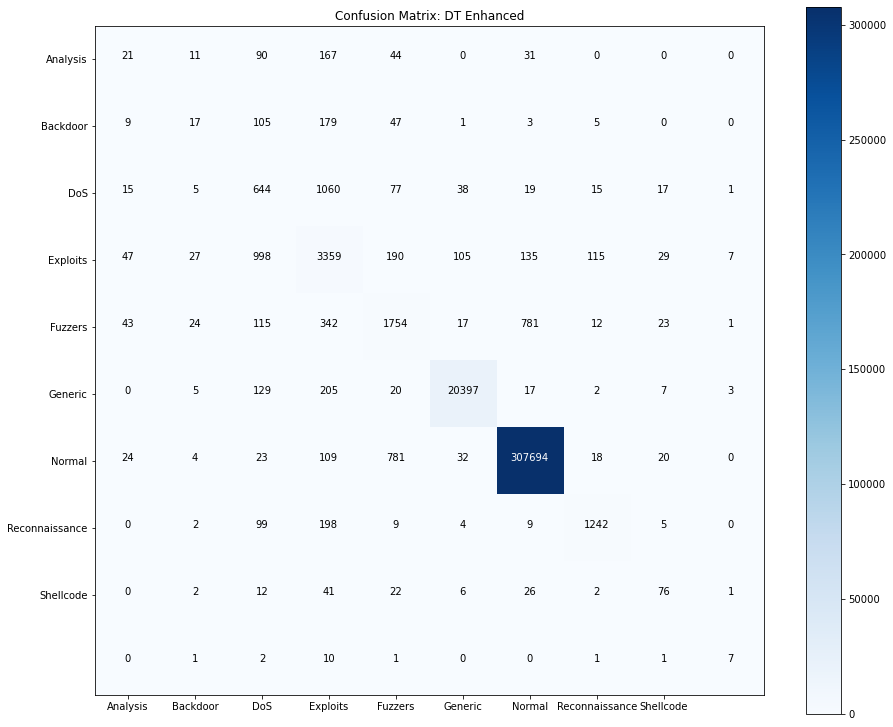

In [16]:
plt.rcParams['figure.figsize'] = [15,13]
cls = ["Analysis","Backdoor","DoS","Exploits","Fuzzers","Generic","Normal","Reconnaissance","Shellcode"]
show_cm(Y_test, prd, class_names=cls, model_name='DT Enhanced')

In [17]:
from sklearn.ensemble import RandomForestClassifier
# fit the model with data
model = RandomForestClassifier().fit(X_train,Y_train)
#fit the model with the testing data
prd = model.predict(X_test)

# Generating the model report
report = model_report(prd,Y_test)
acc= round(accuracy_score(Y_test, prd),3)*100
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",acc)
#report.insert(0, "Class", Clasess, True)
report

Accuracy: 98.3


,precision,recall,f1-score,support
Analysis,1.9,87.5,3.8,8.0
Backdoor,3.8,58.3,7.2,24.0
DoS,14.9,34.4,20.8,819.0
Exploits,84.2,58.0,68.7,7275.0
Fuzzers,60.6,64.4,62.5,2929.0
Generic,98.0,99.5,98.8,20477.0
Normal,99.8,99.7,99.7,308988.0
Reconnaissance,78.8,91.2,84.5,1354.0
Shellcode,45.2,61.2,52.0,139.0
Worms,4.3,100.0,8.3,1.0


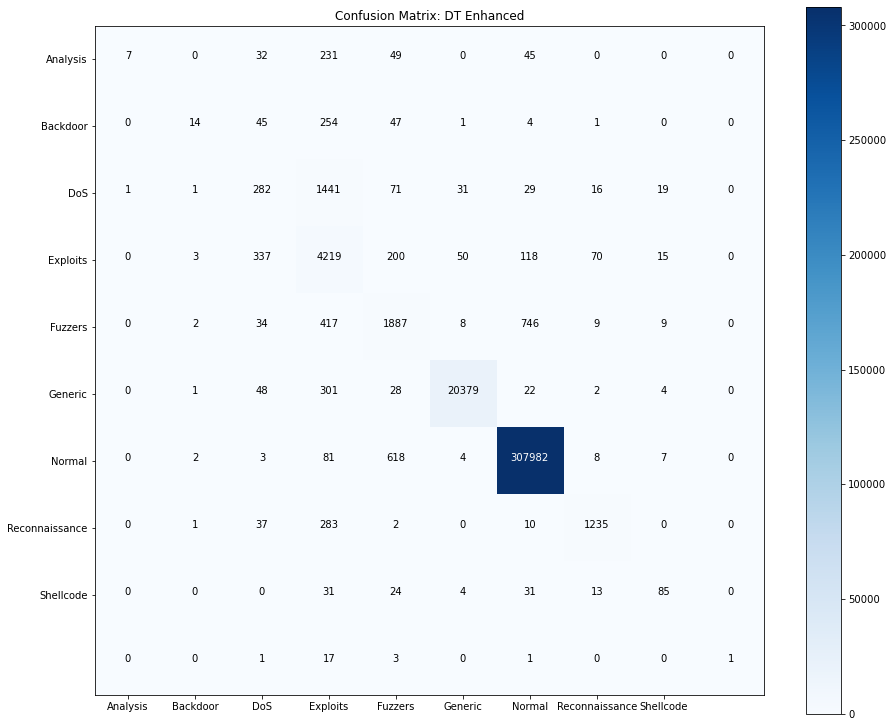

In [18]:
plt.rcParams['figure.figsize'] = [15,13]
cls = ["Analysis","Backdoor","DoS","Exploits","Fuzzers","Generic","Normal","Reconnaissance","Shellcode"]
show_cm(Y_test, prd, class_names=cls, model_name='DT Enhanced')